In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from models import glow
from flows.glow import resnet_glow
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
batch_size = 1
#X_train = np.expand_dims(X_train, axis=-1)
X_train_ds = tf.data.Dataset.from_tensor_slices(X_train.astype(np.float32))
X_train_ds = X_train_ds.map(lambda x: x / 255.).shuffle(buffer_size=1000).batch(batch_size)

In [7]:
#n_vars = np.prod(X_train.shape[1:])
#normal_diag = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros((1,n_vars,)), scale_diag=tf.ones((1,n_vars,)))
#reshape = tfp.bijectors.Reshape(X_train.shape[1:])
#prior = reshape(normal_diag)
prior = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros((1, *X_train.shape[1:])), scale_diag=tf.ones((1, *X_train.shape[1:])))
model = glow.Glow(prior, num_layers=3, depth_per_layer=8, coupling_nn_ctor=resnet_glow(hidden_dims=128),
                  optimizer=tf.keras.optimizers.Adamax(lr=1.0E-4))

In [8]:
from tqdm import tqdm
N = 1000
with tqdm(total=N) as prog:
    loss_hist = []
    nll_hist = []
    for batch in X_train_ds.take(N):
        loss, nll, ildj, grad_norm = model.train_batch(batch)
        loss_hist.append(loss.numpy())
        nll_hist.append(nll.numpy())
        prog.update(batch_size)
        prog.set_postfix({'loss': np.mean(loss_hist), 'nll': np.mean(nll_hist),
                          'ildj': ildj.numpy(),
                          'grad norm': grad_norm.numpy()})

100%|██████████| 1000/1000 [54:42<00:00,  3.28s/it, loss=2.32e+7, nll=2.32e+7, ildj=2.71e+6, grad norm=6.49e+6]


In [9]:
x = model.target_dist.sample()
print(x)
print(tf.math.reduce_mean(model.target_dist.log_prob(x)))
_ = tf.debugging.assert_all_finite(x, 'found nan or inf values')

tf.Tensor(
[[[[-1.5538573   1.7702935   1.5816301 ]
   [-1.2852435  -0.892591   -0.24179149]
   [-1.7428317   0.08099414  1.4197927 ]
   ...
   [ 0.06508758  1.0524348   0.23970585]
   [-0.62057847  0.3063658   1.4455342 ]
   [-2.461542    1.1485254  -1.1975224 ]]

  [[ 1.0668155  -1.0218328   0.45149657]
   [-1.0343399  -0.09447701 -1.266674  ]
   [ 0.9581291  -0.46383575  0.37119427]
   ...
   [ 0.3812227  -0.6397195  -0.07196636]
   [ 1.6462691   0.14078276  1.1592841 ]
   [-1.944432    0.3575421  -1.6368476 ]]

  [[-1.9013448   0.12330469  0.01093638]
   [-0.43890715 -1.2021683  -0.21665731]
   [ 1.1836325  -1.1833553   0.30851415]
   ...
   [ 0.5720683   0.67432773  0.87295103]
   [-0.23186931  1.2826301   0.21995738]
   [ 0.14881164 -0.19464928  1.742219  ]]

  ...

  [[ 1.9977231   1.5693253   1.0518388 ]
   [ 1.7825086   0.64386517 -2.1576688 ]
   [ 0.10101982  0.8240722   1.1742182 ]
   ...
   [-0.6157734  -1.2534294  -0.77405745]
   [ 1.1024866   0.46158564  1.3938475 ]
   [ 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


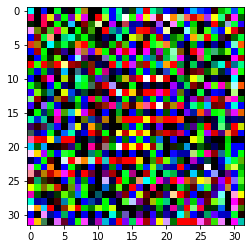

In [10]:
import matplotlib.pyplot as plt
plt.imshow(tf.squeeze(x))